# Word Sense Disambiguation (WSD)
### Sam Timmins, Alex Cerpa, Kas Taghavi

In [1]:
import pandas as pd

def parse_file_to_df(filename):
    with open(filename) as f:
        lines = f.readlines()
        
        data = []
        for i, line in enumerate(lines):
            if '1\n' in lines[i]:
                i = i + 1
                while '2\n' not in lines[i] and lines[i][0] != '\n':
                    temp = lines[i].replace('\"', '')
                    temp = temp.replace('\n', '')
                    data.append((temp, 1))
                    i = i + 1
                last = i
                
        for i in range(last + 2, len(lines)):
            temp = lines[i].replace('\"', '')
            temp = temp.replace('\n', '')
            data.append((temp, 2))
            
        return pd.DataFrame(data, columns =['sentence', 'sense'])

In [2]:
rubbish = parse_file_to_df('rubbish.txt')

In [3]:
tissue = parse_file_to_df('tissue.txt')

In [4]:
yarn = parse_file_to_df('yarn.txt')

In [5]:
dfs = [rubbish, tissue, yarn]

In [6]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

for df in dfs:
    df['sentence'] = df['sentence'].str.replace('[^\w\s]','')
    df['sentence'] = df['sentence'].str.lower()
    df['sentence'] = df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

/var/folders/74/slb24t3j6197703qqtgwj1cw0000gn/T/ipykernel_89268/3217394688.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sentence'] = df['sentence'].str.replace('[^\w\s]','')


In [7]:
rubbish_max_length = dfs[0]['sentence'].str.split().apply(len).max()
rubbish_max_length

24

In [8]:
tissue_max_length = dfs[1]['sentence'].str.split().apply(len).max()
tissue_max_length

22

In [9]:
yarn_max_length = dfs[2]['sentence'].str.split().apply(len).max()
yarn_max_length

25

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import numpy as np

rubbish_X = dfs[0]['sentence'].to_numpy()

NUM_TOP_WORDS = None

rubbish_tokenizer = Tokenizer(num_words=rubbish_max_length)
rubbish_tokenizer.fit_on_texts(rubbish_X)
rubbish_sequences = rubbish_tokenizer.texts_to_sequences(rubbish_X)

rubbish_word_index = rubbish_tokenizer.word_index
NUM_TOP_WORDS = len(rubbish_word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
rubbish_top_words = min((len(rubbish_word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(rubbish_word_index), rubbish_top_words))

rubbish_X = sequence.pad_sequences(rubbish_sequences, maxlen=rubbish_max_length)

print('Shape of data tensor:', rubbish_X.shape)
print(np.max(rubbish_X))

Found 543 unique tokens. Distilled to 543 top words.
Shape of data tensor: (66, 24)
23


In [11]:
tissue_X = dfs[1]['sentence'].to_numpy()

NUM_TOP_WORDS = None

tissue_tokenizer = Tokenizer(num_words=tissue_max_length)
tissue_tokenizer.fit_on_texts(tissue_X)
tissue_sequences = tissue_tokenizer.texts_to_sequences(tissue_X)

tissue_word_index = tissue_tokenizer.word_index
NUM_TOP_WORDS = len(tissue_word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
tissue_top_words = min((len(tissue_word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(tissue_word_index), tissue_top_words))

tissue_X = sequence.pad_sequences(tissue_sequences, maxlen=tissue_max_length)

print('Shape of data tensor:', tissue_X.shape)
print(np.max(tissue_X))

Found 400 unique tokens. Distilled to 400 top words.
Shape of data tensor: (50, 22)
21


In [12]:
yarn_X = dfs[2]['sentence'].to_numpy()

NUM_TOP_WORDS = None

yarn_tokenizer = Tokenizer(num_words=yarn_max_length)
yarn_tokenizer.fit_on_texts(yarn_X)
yarn_sequences = yarn_tokenizer.texts_to_sequences(yarn_X)

yarn_word_index = yarn_tokenizer.word_index
NUM_TOP_WORDS = len(yarn_word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
yarn_top_words = min((len(yarn_word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(yarn_word_index), yarn_top_words))

yarn_X = sequence.pad_sequences(yarn_sequences, maxlen=yarn_max_length)

print('Shape of data tensor:', yarn_X.shape)
print(np.max(yarn_X))

Found 466 unique tokens. Distilled to 466 top words.
Shape of data tensor: (50, 25)
24


In [13]:
from sklearn.model_selection import train_test_split
from tensorflow import keras

rubbish_X_train, rubbish_X_test, rubbish_y_train, rubbish_y_test = train_test_split(rubbish_X, dfs[0]['sense'].to_numpy(), test_size=0.1)
tissue_X_train, tissue_X_test, tissue_y_train, tissue_y_test = train_test_split(tissue_X, dfs[1]['sense'].to_numpy(), test_size=0.1)
yarn_X_train, yarn_X_test, yarn_y_train, yarn_y_test = train_test_split(yarn_X, dfs[2]['sense'].to_numpy(), test_size=0.1)

print('Rubbish: ', len(rubbish_X_train), len(rubbish_X_test))
print('Tissue: ', len(tissue_X_train), len(tissue_X_test))
print('Yarn: ', len(yarn_X_train), len(yarn_X_test))

Rubbish:  59 7
Tissue:  45 5
Yarn:  45 5


In [14]:
EMBED_SIZE = 50

embeddings_index = {}
f = open('glove.6B.50d.txt', encoding="utf8")
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
rubbish_found_words = 0
rubbish_embedding_matrix = np.zeros((len(rubbish_word_index) + 1, EMBED_SIZE))
for word, i in rubbish_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        rubbish_embedding_matrix[i] = embedding_vector
        rubbish_found_words = rubbish_found_words+1

print("Embedding Shape:",rubbish_embedding_matrix.shape, "\n",
      "Total words found:",rubbish_found_words, "\n",
      "Percentage:",100*rubbish_found_words/rubbish_embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (544, 50) 
 Total words found: 511 
 Percentage: 93.93382352941177


In [15]:
# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
tissue_found_words = 0
tissue_embedding_matrix = np.zeros((len(tissue_word_index) + 1, EMBED_SIZE))
for word, i in tissue_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        tissue_embedding_matrix[i] = embedding_vector
        tissue_found_words = tissue_found_words+1

print("Embedding Shape:",tissue_embedding_matrix.shape, "\n",
      "Total words found:",tissue_found_words, "\n",
      "Percentage:",100*tissue_found_words/tissue_embedding_matrix.shape[0])

Embedding Shape: (401, 50) 
 Total words found: 383 
 Percentage: 95.51122194513715


In [16]:
# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
yarn_found_words = 0
yarn_embedding_matrix = np.zeros((len(yarn_word_index) + 1, EMBED_SIZE))
for word, i in yarn_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        yarn_embedding_matrix[i] = embedding_vector
        yarn_found_words = yarn_found_words+1

print("Embedding Shape:",yarn_embedding_matrix.shape, "\n",
      "Total words found:",yarn_found_words, "\n",
      "Percentage:",100*yarn_found_words/yarn_embedding_matrix.shape[0])

Embedding Shape: (467, 50) 
 Total words found: 450 
 Percentage: 96.35974304068523


In [17]:
from tensorflow.keras.layers import Embedding

# create pre-trained embedding layer for each file
rubbish_embedding_layer = Embedding(len(rubbish_word_index) + 1,
                            EMBED_SIZE,
                            weights=[rubbish_embedding_matrix],# here is the embedding getting saved
                            input_length=rubbish_max_length,
                            trainable=False)
tissue_embedding_layer = Embedding(len(tissue_word_index) + 1,
                            EMBED_SIZE,
                            weights=[tissue_embedding_matrix],# here is the embedding getting saved
                            input_length=tissue_max_length,
                            trainable=False)
yarn_embedding_layer = Embedding(len(yarn_word_index) + 1,
                            EMBED_SIZE,
                            weights=[yarn_embedding_matrix],# here is the embedding getting saved
                            input_length=yarn_max_length,
                            trainable=False)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

rubbish_lstm = Sequential()
rubbish_lstm.add(rubbish_embedding_layer)
rubbish_lstm.add(LSTM(300,dropout=0.2, recurrent_dropout=0.2))
rubbish_lstm.add(Dense(1, activation='sigmoid'))
rubbish_lstm.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
rubbish_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 50)            27200     
                                                                 
 lstm (LSTM)                 (None, 300)               421200    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 448,701
Trainable params: 421,501
Non-trainable params: 27,200
_________________________________________________________________


In [19]:
tissue_lstm = Sequential()
tissue_lstm.add(tissue_embedding_layer)
tissue_lstm.add(LSTM(300,dropout=0.2, recurrent_dropout=0.2))
tissue_lstm.add(Dense(1, activation='sigmoid'))
tissue_lstm.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
tissue_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 22, 50)            20050     
                                                                 
 lstm_1 (LSTM)               (None, 300)               421200    
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                                 
Total params: 441,551
Trainable params: 421,501
Non-trainable params: 20,050
_________________________________________________________________


In [20]:
yarn_lstm = Sequential()
yarn_lstm.add(yarn_embedding_layer)
yarn_lstm.add(LSTM(300,dropout=0.2, recurrent_dropout=0.2))
yarn_lstm.add(Dense(1, activation='sigmoid'))
yarn_lstm.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
yarn_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 50)            23350     
                                                                 
 lstm_2 (LSTM)               (None, 300)               421200    
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 444,851
Trainable params: 421,501
Non-trainable params: 23,350
_________________________________________________________________


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

rubbish_custom_callbacks = [
    ModelCheckpoint(
        filepath = 'LSTMs/rubbish_lstm.h5',
        monitor = 'val_accuracy',
        mode = 'max',
        verbose = 1,
        save_best_only = True
    )
]

tissue_custom_callbacks = [
    ModelCheckpoint(
        filepath = 'LSTMs/tissue_lstm.h5',
        monitor = 'val_accuracy',
        mode = 'max',
        verbose = 1,
        save_best_only = True
    )
]

yarn_custom_callbacks = [
    ModelCheckpoint(
        filepath = 'LSTMs/yarn_lstm.h5',
        monitor = 'val_accuracy',
        mode = 'max',
        verbose = 1,
        save_best_only = True
    )
]

In [22]:
rubbish_history = rubbish_lstm.fit(rubbish_X_train, rubbish_y_train, validation_data=(rubbish_X_test, rubbish_y_test), 
                   epochs=50, batch_size=8, callbacks=rubbish_custom_callbacks)

Epoch 1/50


2023-04-20 15:30:35.195013: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/8 [=========================>....] - ETA: 0s - loss: -3.2676 - accuracy: 0.4286
Epoch 1: val_accuracy improved from -inf to 0.42857, saving model to LSTMs/rubbish_lstm.h5
8/8 [==============================] - 1s 66ms/step - loss: -3.4606 - accuracy: 0.4407 - val_loss: -12.6730 - val_accuracy: 0.4286
Epoch 2/50
7/8 [=========================>....] - ETA: 0s - loss: -11.8229 - accuracy: 0.5179
Epoch 2: val_accuracy did not improve from 0.42857
8/8 [==============================] - 0s 49ms/step - loss: -12.1296 - accuracy: 0.5085 - val_loss: -15.5901 - val_accuracy: 0.4286
Epoch 3/50
7/8 [=========================>....] - ETA: 0s - loss: -13.1309 - accuracy: 0.5357
Epoch 3: val_accuracy did not improve from 0.42857
8/8 [==============================] - 0s 49ms/step - loss: -13.9674 - accuracy: 0.5085 - val_loss: -17.2551 - val_accuracy: 0.4286
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: -14.9582 - accuracy: 0.5179
Epoch 4: val_accuracy did not improve from 0.428

In [23]:
tissue_history = tissue_lstm.fit(tissue_X_train, tissue_y_train, validation_data=(tissue_X_test, tissue_y_test), 
                   epochs=50, batch_size=8, callbacks=tissue_custom_callbacks)

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: -1.0054 - accuracy: 0.5111
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to LSTMs/tissue_lstm.h5
6/6 [==============================] - 1s 57ms/step - loss: -1.0054 - accuracy: 0.5111 - val_loss: -10.4280 - val_accuracy: 0.4000
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: -10.5832 - accuracy: 0.5000
Epoch 2: val_accuracy did not improve from 0.40000
6/6 [==============================] - 0s 48ms/step - loss: -10.4981 - accuracy: 0.5111 - val_loss: -15.1504 - val_accuracy: 0.4000
Epoch 3/50
5/6 [========================>.....] - ETA: 0s - loss: -13.1454 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 0.40000
6/6 [==============================] - 0s 49ms/step - loss: -12.9134 - accuracy: 0.5111 - val_loss: -16.8319 - val_accuracy: 0.4000
Epoch 4/50
5/6 [========================>.....] - ETA: 0s - loss: -15.1161 - accuracy: 0.4750
Epoch 4: val_accuracy did not improve 

In [24]:
yarn_history = yarn_lstm.fit(yarn_X_train, yarn_y_train, validation_data=(yarn_X_test, yarn_y_test), 
                   epochs=50, batch_size=8, callbacks=yarn_custom_callbacks)

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: -2.1721 - accuracy: 0.4667
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to LSTMs/yarn_lstm.h5
6/6 [==============================] - 1s 69ms/step - loss: -2.1721 - accuracy: 0.4667 - val_loss: -3.8145 - val_accuracy: 0.8000
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: -12.0671 - accuracy: 0.4667
Epoch 2: val_accuracy did not improve from 0.80000
6/6 [==============================] - 0s 66ms/step - loss: -12.0671 - accuracy: 0.4667 - val_loss: -5.0882 - val_accuracy: 0.8000
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: -14.2412 - accuracy: 0.4667
Epoch 3: val_accuracy did not improve from 0.80000
6/6 [==============================] - 0s 56ms/step - loss: -14.2412 - accuracy: 0.4667 - val_loss: -5.6310 - val_accuracy: 0.8000
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: -15.5034 - accuracy: 0.4667
Epoch 4: val_accuracy did not improve from 

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt

def plotHistory(history):
    # summarize history for accuracy
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

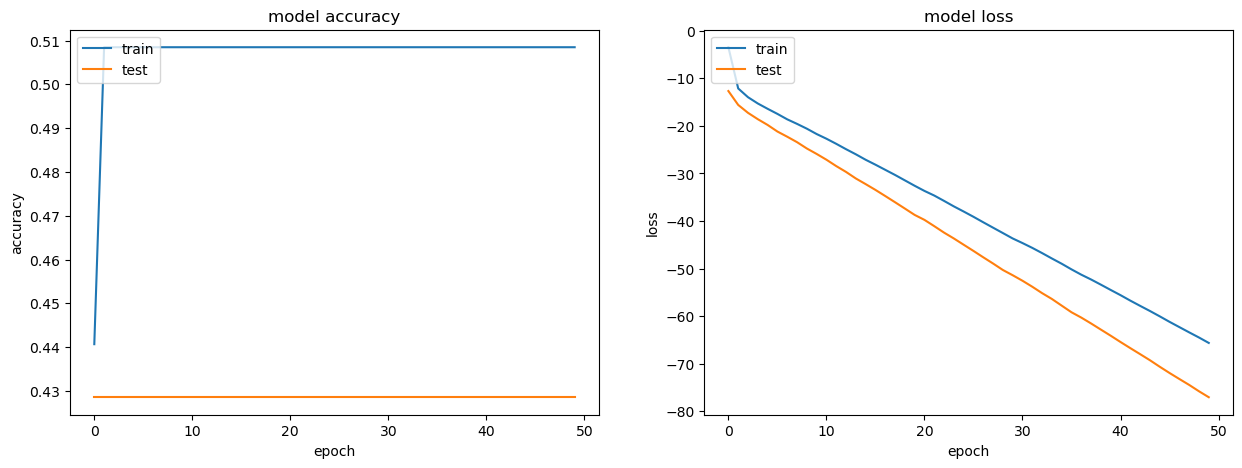

In [26]:
plotHistory(rubbish_history.history)

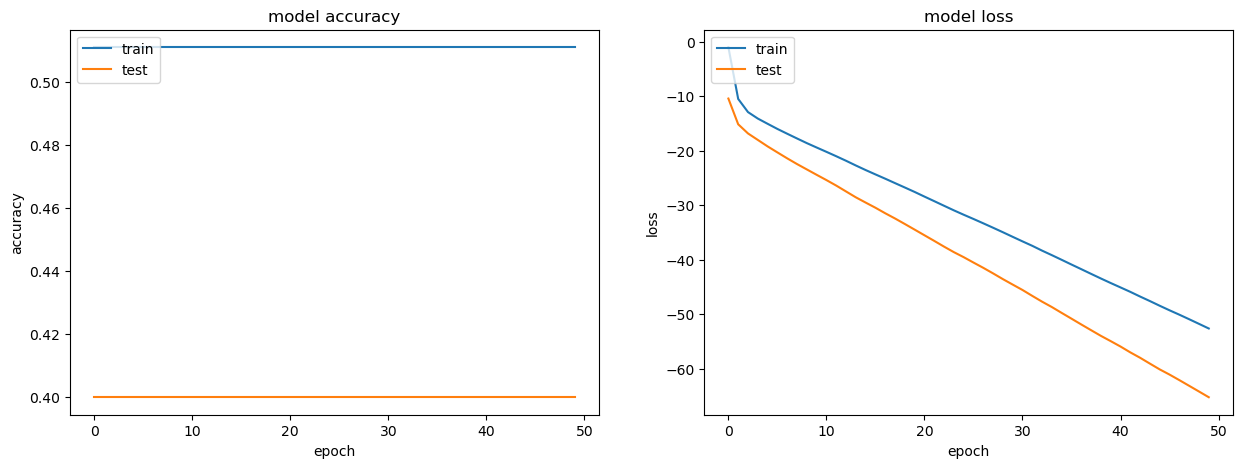

In [27]:
plotHistory(tissue_history.history)

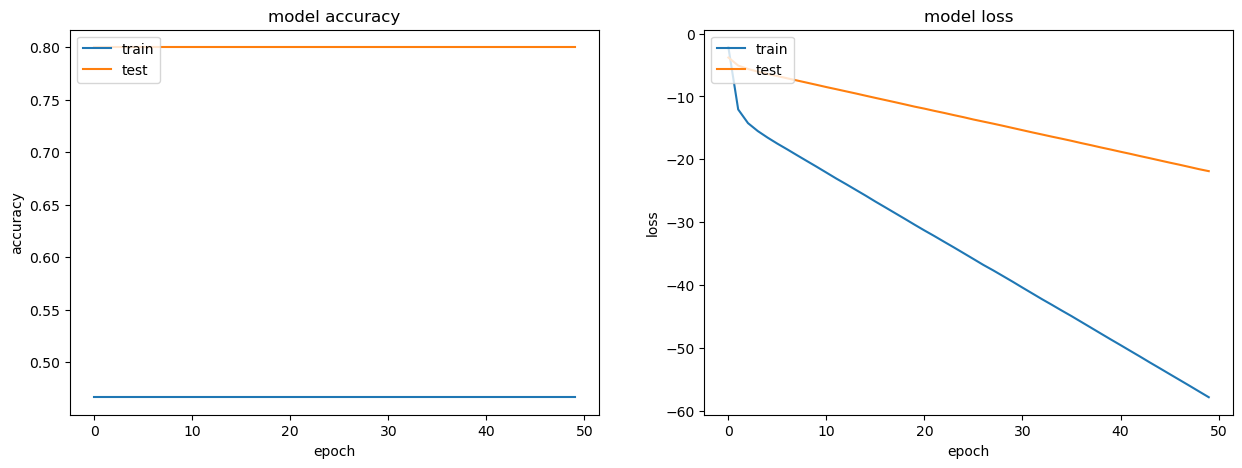

In [28]:
plotHistory(yarn_history.history)